In [6]:
if False:
    LOG_DIR = "../workbox/logs_synthetic/sd"

In [7]:
import os

LOG_PATH = os.path.join(LOG_DIR, "training.log")
PERF_PATH = os.path.join(os.path.join(LOG_DIR, "models"), "performance.csv")
XGB_LOG = os.path.join(LOG_DIR, "xgboost.log")

In [8]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import animation, rc
from operator import itemgetter

rc('animation', html='html5')

In [9]:
channel_status = []
with open(LOG_PATH) as f:
    channel_status = list(filter(lambda s: "channel status" in s, f))

In [10]:
channels = {}
for line in channel_status:
    line = line.strip().split(', ')
    (name, _, income, _, outcome) = line[-5:]
    timestamp = line[1]
    if name not in channels:
        channels[name] = []
    channels[name].append(
        (float(timestamp), float(income), float(outcome))
    )

In [11]:
def get_key(s):
    if s[0].startswith("stratum"):
        return (1, -int(s[0][s[0].find('(') + 1:-1]))
    return (0, s[0])


VERTICAL_LINE = None
freq_rank = sorted(list(map(lambda k: (k, len(channels[k])), channels)),
                   key=get_key, reverse=False)
len(freq_rank)

11

In [12]:
def plot_strata():
    COL = 2
    ROW = int((len(freq_rank) + COL - 1) / COL)
    fig, ax = plt.subplots(ROW, COL, figsize=(10 * COL, 6 * ROW))
    color = ['r', 'b']
    for i, (name, cnt) in enumerate(freq_rank[:]):
        for j in [1, 2]:
            x = list(map(itemgetter(0), channels[name]))
            y = list(map(itemgetter(j), channels[name]))
            if j == 1:
                y = [val + 10 for val in y]
                label = "Enqueue"
            else:
                y = [val - 110 for val in y]
                label = "Dequeue"

            ax[int(i / COL)][i % COL].scatter(x, y, c=color[j - 1], label=label)
            ax[int(i / COL)][i % COL].set_title("Channel: %s, Sampled Freq: %d" % (name, cnt))
            ax[int(i / COL)][i % COL].set_xlabel("Inqueue Blocking Rate (%)")
            ax[int(i / COL)][i % COL].set_ylabel("Outqueue Blocking Rate (%)")
            ax[int(i / COL)][i % COL].set_ylim([-105, 105])
            ax[int(i / COL)][i % COL].grid(True)
            ax[int(i / COL)][i % COL].legend(loc=2)

            if VERTICAL_LINE is not None:
                ax[int(i / COL)][i % COL].axvline(VERTICAL_LINE)
            ax[int(i / COL)][i % COL].set_yticks(list(range(-110, 0, 10)) + list(range(10, 110, 10)))
            ax[int(i / COL)][i % COL].set_yticklabels(
                list(range(0, 105, 10)) + [''] + list(range(0, 105, 10)))

            # ax[int(i / COL)][i % COL].set_xlim([0, 1500])

# plot_strata()

## ESS

In [25]:
import pandas as pd


lines = []
with open(LOG_PATH) as f:
    lines = list(filter(lambda s: "reset" in s, f))
ess = []
for line in lines:
    line = line.strip().split(', ')
    ts, val = line[1], line[-1]
    ess.append((float(ts), float(val)))

lines = []
with open(LOG_PATH) as f:
    lines = list(filter(lambda s: "switched-buffer" in s, f))
switched = []
for line in lines:
    line = line.strip().split(', ')
    switched.append(float(line[1]))

lines = []
with open(LOG_PATH) as f:
    lines = list(filter(lambda s: "tree-node-info" in s, f))
tree_info = []
for line in lines:
    line = line.strip().split(', ')
    ts, scanned, edge = line[1], line[4], line[5]
    tree_info.append((float(ts), int(scanned), float(edge)))

lines = []
with open(LOG_PATH) as f:
    lines = list(filter(lambda s: "Validation" in s, f))
validation = []
for line in lines:
    line = line.strip().split(', ')
    ts, val = line[1], line[-1].rsplit(' ', 1)[1]
    validation.append((float(ts), float(val)))


def plot_by_time():
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))

    x = list(map(itemgetter(0), ess))
    y = list(map(itemgetter(1), ess))
    ax[0].plot(x, y, label="ESS")
    for ts in switched:
        ax[0].axvline(ts, c='yellow')

    x = list(map(itemgetter(0), tree_info))
    y = list(map(itemgetter(2), tree_info))
    ax[0].plot(x, y, label="Edge of the tree")
    ax[0].grid();
    ax[0].set_title("Effective Sample Size");
    ax[0].set_xlabel("Time stamp")
    ax[0].legend()

    x = list(map(itemgetter(0), tree_info))
    y = list(range(1, len(tree_info) + 1))
    ax[1].scatter(x, y)
    ax[1].grid();
    ax[1].set_title("Number of tree nodes");
    ax[1].set_xlabel("Time stamp")
    ax[1].set_ylabel("Number of tree nodes");


    x = list(map(itemgetter(0), validation))
    y = list(map(itemgetter(1), validation))
    ax[2].scatter(x, y)
    ax[2].grid();
    ax[2].set_title("Potential (Exponential Loss)");
    ax[2].set_xlabel("Time stamp")
    ax[2].set_ylabel("Potential (Exponential Loss)");

In [54]:
performance = pd.read_csv(
    PERF_PATH,
    names=["filename", "timestamp", "size", "potential", "AUPRC", "AUROC"]
)


def plot_performance(ax, by, y):
    for i, name in enumerate(y):
        performance.plot(
            x=by, y=name, ax=ax[i]
        )
        ax[i].grid()
        ax[i].set_title(name)

def plot_by_timestamp(ax):
    plot_performance(ax, "timestamp", ["size", "potential", "AUPRC", "AUROC"])

def plot_by_size(ax):
    plot_performance(ax, "size", ["potential", "AUPRC", "AUROC"])

In [32]:
# fig, ax = plt.subplots(3, 2, figsize=(20, 18))
# plot_by_size([ax[i][0] for i in range(3)])

# XGBoost logs

In [55]:
lines = []
with open(XGB_LOG) as f:
    lines = list(filter(lambda s: "eval," in s, f))
v_size, v_potential, v_auprc, v_auroc = [], [], [], []
for line in lines:
    line = line.strip().split(',')
    size, potential, auprc, auroc = line[-4:]
    v_size.append(int(size))
    v_potential.append(float(potential))
    v_auprc.append(float(auprc))
    v_auroc.append(float(auroc))
lines = []
with open(XGB_LOG) as f:
    lines = list(filter(lambda s: "new tree," in s, f))
v_ts = []
for line in lines:
    line = line.strip().split(',')
    ts = line[0]
    v_ts.append(float(ts))

xgb = pd.DataFrame(data={
    "XGB ts": v_ts,
    "XGB size": v_size,
    "XGB potential": v_potential,
    "XGB AUPRC": v_auprc,
    "XGB AUROC": v_auroc,
})

In [60]:
def plot_xgb_performance(ax, by, y):
    for i, name in enumerate(y):
        xgb.plot(
            x=by, y=name, ax=ax[i]
        )
        ax[i].grid()
        ax[i].set_title(name)


def plot_xgb_by_timestamp(ax):
    plot_xgb_performance(ax, "XGB ts", ["XGB size", "XGB potential", "XGB AUPRC", "XGB AUROC"])


def plot_xgb_by_size(ax):
    plot_xgb_performance(ax, "XGB size", ["XGB potential", "XGB AUPRC", "XGB AUROC"])

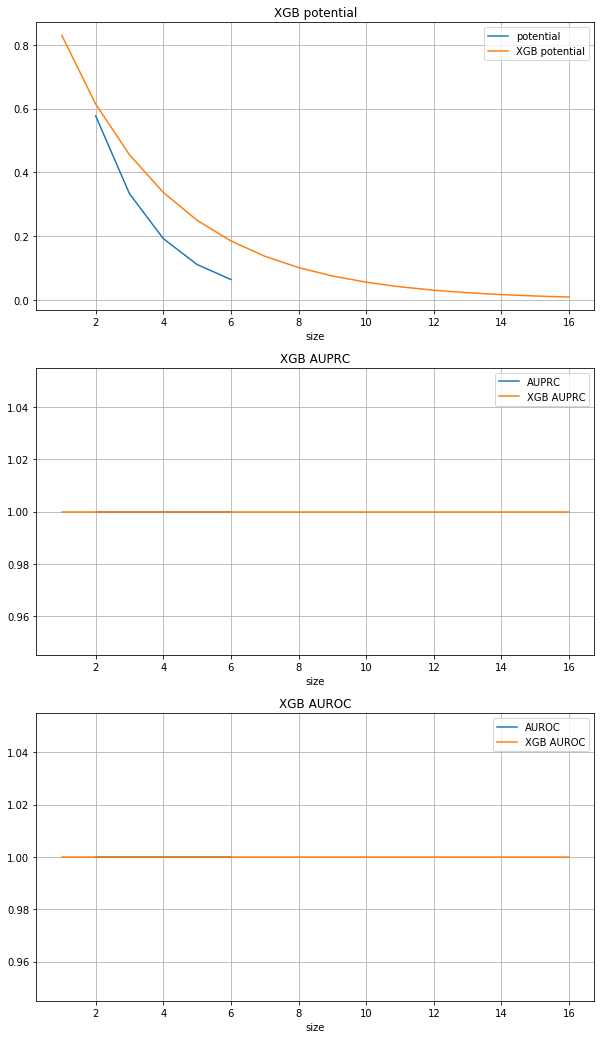

In [59]:
# fig, ax = plt.subplots(3, 1, figsize=(10, 18))
# plot_by_size(ax)
# plot_xgb_by_size(ax)

# Weights distribution

In [14]:
with open(LOG_PATH) as f:
    lines = f.readlines()
    weights = list(filter(lambda s: "strata weights distr" in s, lines))
    counts = list(filter(lambda s: "strata counts distr" in s, lines))

weights_distr = []
counts_distr = []
for i in range(len(weights)):
    index = weights[i].find("strata weights distr")
    pairs = weights[i][index:].strip().split(", ", 1)[1].rsplit(", ", 1)[0][1:-1].split("), (")
    x = list(map(lambda s: int(s.split(', ')[0]), pairs))
    y = list(map(lambda s: float(s.split(', ')[1]), pairs))
    weights_distr.append((x, y))

    index = counts[i].find("strata counts distr")
    pairs = counts[i][index:].strip().split(", ", 1)[1].rsplit(", ", 1)[0][1:-1].split("), (")
    x = list(map(lambda s: int(s.split(', ')[0]), pairs))
    y = list(map(lambda s: float(s.split(', ')[1]), pairs))
    counts_distr.append((x, y))

In [15]:
all_w = set([])
for (w, d) in weights_distr:
    all_w = all_w.union(w)
all_w = sorted(list(all_w))
for i in range(len(weights_distr)):
    x, y = weights_distr[i]
    xymap = {a: b for a, b in zip(x, y)}
    weights_distr[i] = (all_w, [xymap.get(k, 0.0) for k in all_w])
    x, y = counts_distr[i]
    xymap = {a: b for a, b in zip(x, y)}
    counts_distr[i] = (all_w, [xymap.get(k, 0.0) for k in all_w])

len(weights_distr), len(counts_distr)

(27, 27)

In [ ]:
"""
import numpy as np
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

line0a, = ax[0].plot(weights_distr[6000][0], weights_distr[6000][1], label="PDF")
line1a, = ax[1].plot(counts_distr[6000][0], counts_distr[6000][1], label="PDF")

line0b, = ax[0].plot(weights_distr[6000][0], np.cumsum(weights_distr[6000][1]), label="CDF")
line1b, = ax[1].plot(counts_distr[6000][0], np.cumsum(counts_distr[6000][1]), label="CDF")

ax[0].legend(loc=1)
ax[1].legend(loc=1)

ax[0].set_ylim(0.0, 100.0)
ax[0].set_title("Weights Distribution")
ax[1].set_ylim(0.0, 100.0)
ax[1].set_title("Distribution of the Number of Examples")

ax[0].set_xlabel("Strata Index (log of weight)")
ax[1].set_xlabel("Strata Index (log of weight)")
ax[0].set_ylabel("%")


def update(i):
    label = 'timestep {0}'.format(i)
    line0a.set_ydata(weights_distr[i][1])
    line1a.set_ydata(counts_distr[i][1])
    line0b.set_ydata(np.cumsum(weights_distr[i][1]))
    line1b.set_ydata(np.cumsum(counts_distr[i][1]))
    fig.suptitle(label)
    return line, ax


anim = FuncAnimation(fig, update,
                     frames=np.arange(0, 2000, 10),
                     interval=100)
anim
"""